# March Madness Machine Learning Predictor

## Introduction

The project is to build a machine learning model to predict NCAA Tournament Winners based on historical data and team stats.This is done by using the top NCAA Teams to build a training set to predict who wins in a match up between through teams.It is building a model that will take in a single team and decide if they are gonna win a game.The input to the machine learning model is a match up between 2 teams, and important information about the team involved such as the teams overall league rankings - different teams ranked for different categories along with average number of points per game, average defenisve rating per game, average speed of pace for a game.

## Import Libraries

In [ ]:
pip install catboost

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import resample, shuffle

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score, make_scorer

from sklearn.preprocessing import StandardScaler

In [ ]:
team_matchups = pd.read_csv('datasets/team_matchups.csv')

## Data Preprocessing

In [ ]:
#output of first 5 rows of initial dataset
team_matchups.head()

,team1,team1_bpi,team2,team2_bpi,team1_points,team2_points,points_difference,offensive_efficiency_team1,offensive_efficiency_team2,offensive_efficiency_difference,...,team2_efgpct,efgpct_difference,team1_experience,team2_experience,experience_difference,team1_rating,team2_rating,rating_difference,team1_winner,team2_winner
0,Baylor Bears,21,Gonzaga Bulldogs,9,63,101,38,121.1,125.2,4.1,...,56.41,4.36,2.72,2.97,0.12,20.3,27.3,7.0,0,1
1,Ohio State Buckeyes,35,Texas Longhorns,34,80,72,8,118.1,116.7,1.4,...,52.90,0.81,2.16,2.85,1.46,19.5,16.0,3.5,1,0
2,North Carolina Tar Heels,27,Kansas Jayhawks,11,89,92,3,119.2,115.4,3.8,...,53.14,1.12,2.24,3.62,0.01,17.2,23.2,6.0,0,1
3,New Mexico Lobos,49,UCLA Bruins,26,72,64,8,113.7,116.5,2.8,...,52.94,1.69,2.45,2.23,0.19,17.1,21.5,4.4,1,0
4,Auburn Tigers,3,Houston Cougars,2,74,69,5,130.7,124.9,5.8,...,53.21,2.84,2.79,2.63,1.25,37.6,35.4,2.2,1,0


In [ ]:
team_matchups = team_matchups.drop(columns=['team2_winner'])  # Drop specific columns
team_matchups = team_matchups.rename(columns={'team1_winner': 'winner'})  # Rename columns

In [ ]:
team_matchups.head()

,team1,team1_bpi,team2,team2_bpi,team1_points,team2_points,points_difference,offensive_efficiency_team1,offensive_efficiency_team2,offensive_efficiency_difference,...,team1_efgpct,team2_efgpct,efgpct_difference,team1_experience,team2_experience,experience_difference,team1_rating,team2_rating,rating_difference,winner
0,Baylor Bears,21,Gonzaga Bulldogs,9,63,101,38,121.1,125.2,4.1,...,52.05,56.41,4.36,2.72,2.97,0.12,20.3,27.3,7.0,0
1,Ohio State Buckeyes,35,Texas Longhorns,34,80,72,8,118.1,116.7,1.4,...,53.70,52.90,0.81,2.16,2.85,1.46,19.5,16.0,3.5,1
2,North Carolina Tar Heels,27,Kansas Jayhawks,11,89,92,3,119.2,115.4,3.8,...,54.26,53.14,1.12,2.24,3.62,0.01,17.2,23.2,6.0,0
3,New Mexico Lobos,49,UCLA Bruins,26,72,64,8,113.7,116.5,2.8,...,51.25,52.94,1.69,2.45,2.23,0.19,17.1,21.5,4.4,1
4,Auburn Tigers,3,Houston Cougars,2,74,69,5,130.7,124.9,5.8,...,56.05,53.21,2.84,2.79,2.63,1.25,37.6,35.4,2.2,1


In [ ]:
n_rows, n_cols = team_matchups.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns")

The DataFrame has 358 rows and 26 columns


In [ ]:
#output of dataset column names, data types & presence of any null values
team_matchups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   team1                            358 non-null    object 
 1   team1_bpi                        358 non-null    int64  
 2   team2                            358 non-null    object 
 3   team2_bpi                        358 non-null    int64  
 4   team1_points                     358 non-null    int64  
 5   team2_points                     358 non-null    int64  
 6   points_difference                358 non-null    int64  
 7   offensive_efficiency_team1       358 non-null    float64
 8   offensive_efficiency_team2       358 non-null    float64
 9   offensive_efficiency_difference  358 non-null    float64
 10  defensive_efficiency_team1       358 non-null    float64
 11  defensive_efficiency_team2       358 non-null    float64
 12  defensive_efficiency_d

In [ ]:
team_matchups.describe()

,team1_bpi,team2_bpi,team1_points,team2_points,points_difference,offensive_efficiency_team1,offensive_efficiency_team2,offensive_efficiency_difference,defensive_efficiency_team1,defensive_efficiency_team2,...,team1_efgpct,team2_efgpct,efgpct_difference,team1_experience,team2_experience,experience_difference,team1_rating,team2_rating,rating_difference,winner
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,...,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,27.952514,28.536313,73.011173,76.846369,10.832402,119.153631,119.027654,5.494134,97.176536,97.221229,...,53.474246,53.388101,2.702793,2.467765,2.443296,0.599972,21.991899,21.852793,7.780447,0.405028
std,18.231640,18.704021,11.947358,11.241997,8.423314,4.882597,4.938098,4.182415,4.154604,4.209459,...,2.241590,2.291111,1.919576,0.537955,0.508252,0.435270,6.509903,6.712965,5.432907,0.491585
min,1.000000,1.000000,36.000000,40.000000,1.000000,107.100000,107.100000,0.000000,87.200000,87.200000,...,47.580000,47.580000,0.000000,1.070000,1.070000,0.000000,9.700000,9.700000,0.000000,0.000000
25%,12.000000,13.000000,65.250000,69.000000,4.000000,115.900000,115.900000,2.025000,95.000000,95.000000,...,52.130000,52.130000,1.272500,2.140000,2.140000,0.250000,16.600000,16.600000,3.500000,0.000000
50%,24.500000,25.000000,73.000000,76.000000,8.500000,118.400000,118.400000,4.350000,97.650000,97.400000,...,53.210000,53.210000,2.335000,2.510000,2.510000,0.530000,22.100000,22.100000,6.950000,0.000000
75%,41.000000,43.000000,80.750000,83.000000,15.000000,122.400000,122.400000,8.200000,100.375000,100.400000,...,55.360000,55.080000,3.900000,2.820000,2.790000,0.827500,25.650000,25.200000,11.000000,1.000000
max,64.000000,66.000000,110.000000,116.000000,43.000000,130.700000,130.700000,18.900000,107.000000,107.000000,...,57.790000,57.790000,10.210000,3.620000,3.620000,2.390000,39.100000,39.100000,25.700000,1.000000


### Duplicates

In [ ]:
duplicates = team_matchups[team_matchups.duplicated()]
display(f"Number of duplicated data: {duplicates.shape[0]}")

'Number of duplicated data: 1'

In [ ]:
display(duplicates)

,team1,team1_bpi,team2,team2_bpi,team1_points,team2_points,points_difference,offensive_efficiency_team1,offensive_efficiency_team2,offensive_efficiency_difference,...,team1_efgpct,team2_efgpct,efgpct_difference,team1_experience,team2_experience,experience_difference,team1_rating,team2_rating,rating_difference,winner
84,UCLA Bruins,26,Arizona Wildcats,10,57,54,3,116.5,120.2,3.7,...,52.94,52.14,0.8,2.23,2.72,0.49,21.5,25.2,3.7,1


In [ ]:
team_matchups = team_matchups.drop_duplicates()

In [ ]:
duplicates = team_matchups[team_matchups.duplicated()]
display(f"Number of duplicated data: {duplicates.shape[0]}")

'Number of duplicated data: 0'

## Exploratory Data Analysis

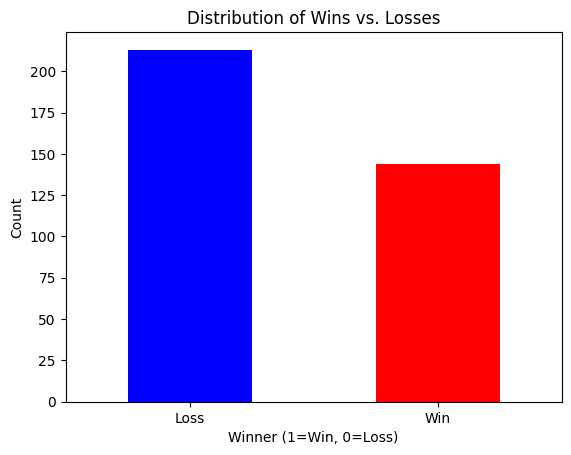

In [ ]:
# Plot target variable distribution
team_matchups['winner'].value_counts().plot(kind='bar', color=['blue', 'red'])

plt.title("Distribution of Wins vs. Losses")
plt.xlabel("Winner (1=Win, 0=Loss)")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=['Loss', 'Win'], rotation=0)
plt.show()


The "Distribution of Wins vs. Losses" bar chart shows the number of wins and losses. The y-axis is labeled "Count," while the x-axis is labelled "Winner (1=Win, 0=Loss)". There are approximately 125 loses (labeled "Loss") and 175 wins (labeled "Win"), according to the chart. It means that wins are more common than losses in the dataset under study.

In [ ]:
# Selecting key numeric features for distribution plots
numeric_features = [
    "team1_bpi", "team2_bpi", "offensive_efficiency_team1", "offensive_efficiency_team2",
    "defensive_efficiency_team1", "defensive_efficiency_team2", "team1_tempo", "team2_tempo",
    "team1_efgpct", "team2_efgpct", "team1_experience", "team2_experience", "team1_rating", "team2_rating"
]


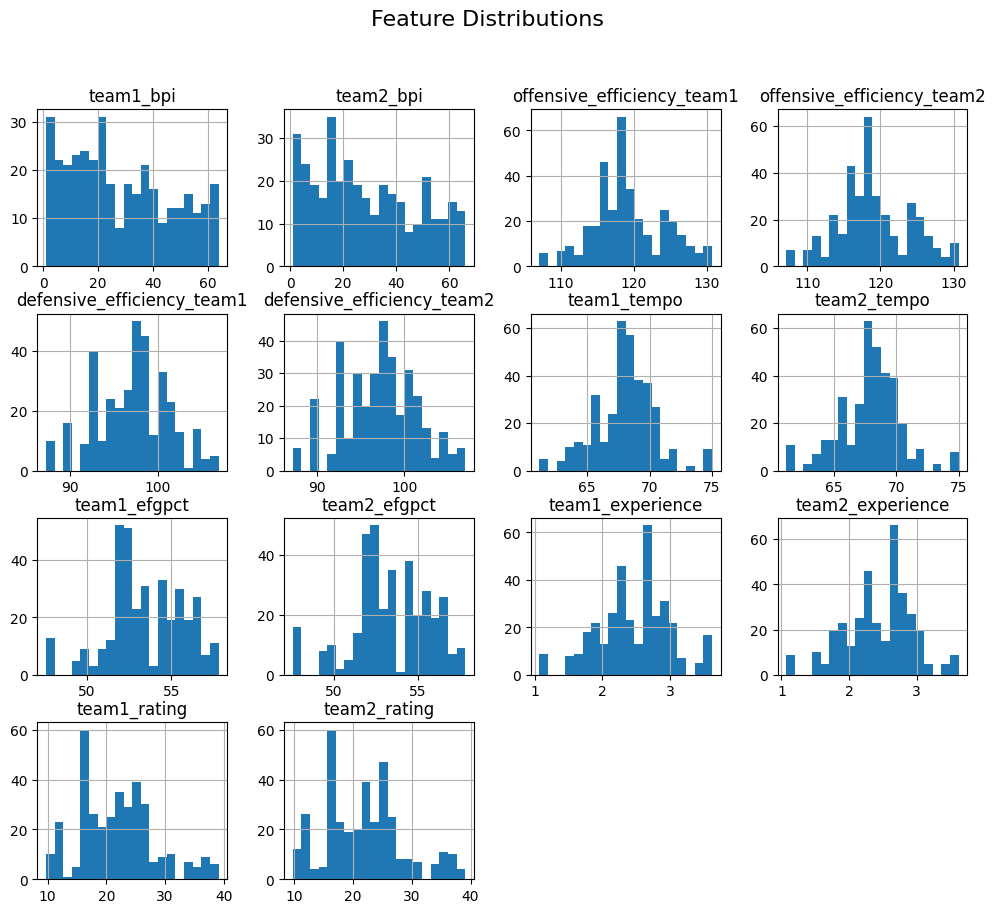

In [ ]:
# Plot histograms for selected features
team_matchups[numeric_features].hist(figsize=(12, 10), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

1. team1_bpi: Skewed distribution with most teams having lower BPI values.
2. team2_bpi: Similar to team1_bpi, indicating most teams have a lower BPI ranking.
3. offensive_efficiency_team1: Peaks around 115-125, showing most teams have similar offensive efficiency.
4. offensive_efficiency_team2: Follows the same trend as team1, reinforcing offensive balance.
5. defensive_efficiency_team1: Concentrated around 90-100, suggesting defensive consistency.
6. defensive_efficiency_team2: Mirrors team1's defensive efficiency, with minimal variation.
7. team1_tempo: Normal distribution centered around 67-70, indicating moderate game speed.
8. team2_tempo: Matches team1_tempo, showing pace consistency among teams.
9. team1_efgpct: Peaks around 50-55%, meaning most teams have similar shooting efficiency.
10. team2_efgpct: Follows the same pattern as team1, confirming shooting consistency.
11. team1_experience: Most teams have 2-3 years of experience, suggesting a mix of veterans and younger players.
12. team2_experience: Similar to team1, reinforcing balanced team compositions.
13. team1_rating: Spread between 10-40, indicating a wide range of team rankings.
14. team2_rating: Follows the same spread, confirming ranking variability among matchups.

In [ ]:
# Select only numeric columns
numeric_team_matchups = team_matchups.select_dtypes(include=['number'])

In [ ]:
# Compute the correlation matrix
corr_matrix = numeric_team_matchups.corr()

In [ ]:
# output of the correlation matrix
corr_matrix

,team1_bpi,team2_bpi,team1_points,team2_points,points_difference,offensive_efficiency_team1,offensive_efficiency_team2,offensive_efficiency_difference,defensive_efficiency_team1,defensive_efficiency_team2,...,team1_efgpct,team2_efgpct,efgpct_difference,team1_experience,team2_experience,experience_difference,team1_rating,team2_rating,rating_difference,winner
team1_bpi,1.000000,-0.138804,-0.245618,0.134275,0.124985,-0.665813,0.023510,-0.001070,0.515510,-0.114397,...,-0.364155,-0.022965,0.004899,-0.134993,-0.030603,-0.009682,-0.827775,0.088552,-0.006737,-0.262126
team2_bpi,-0.138804,1.000000,0.122270,-0.274534,-0.193307,0.062656,-0.683541,-0.072274,-0.056446,0.542877,...,0.055376,-0.343830,-0.022294,0.031819,-0.150513,-0.021439,0.082498,-0.835141,-0.091432,0.219582
team1_points,-0.245618,0.122270,1.000000,0.352256,-0.218342,0.401996,-0.034416,-0.091605,0.014197,0.262300,...,0.275699,0.050834,-0.069425,0.055515,-0.037452,-0.027324,0.288053,-0.183765,-0.065793,0.457539
team2_points,0.134275,-0.274534,0.352256,1.000000,0.198142,0.069132,0.309069,-0.042972,0.379836,-0.024928,...,0.144452,0.262292,-0.013857,0.017224,0.059326,-0.016809,-0.197101,0.243493,-0.031253,-0.430719
points_difference,0.124985,-0.193307,-0.218342,0.198142,1.000000,-0.072846,0.261639,0.143365,0.121715,-0.126544,...,-0.005782,0.148209,-0.014230,-0.065958,0.012544,0.071469,-0.131027,0.263866,0.245199,-0.204983
offensive_efficiency_team1,-0.665813,0.062656,0.401996,0.069132,-0.072846,1.000000,0.012303,0.083361,-0.036184,0.031058,...,0.704564,-0.004158,-0.047430,0.096566,-0.016843,-0.118706,0.765059,-0.001015,0.080828,0.249319
offensive_efficiency_team2,0.023510,-0.683541,-0.034416,0.309069,0.261639,0.012303,1.000000,0.110733,-0.027788,-0.061448,...,-0.055966,0.708638,-0.040353,-0.004334,0.152673,-0.041469,0.023997,0.778034,0.149940,-0.125016
offensive_efficiency_difference,-0.001070,-0.072274,-0.091605,-0.042972,0.143365,0.083361,0.110733,1.000000,-0.046895,-0.094981,...,0.037019,0.015968,0.367545,-0.038067,-0.058449,0.150003,0.095181,0.161980,0.554778,0.015596
defensive_efficiency_team1,0.515510,-0.056446,0.014197,0.379836,0.121715,-0.036184,-0.027788,-0.046895,1.000000,-0.116787,...,0.265999,-0.036895,-0.031612,-0.101133,-0.069599,-0.094061,-0.667654,0.047858,-0.066365,-0.233180
defensive_efficiency_team2,-0.114397,0.542877,0.262300,-0.024928,-0.126544,0.031058,-0.061448,-0.094981,-0.116787,1.000000,...,-0.025297,0.289201,-0.051397,0.049252,-0.093873,-0.030312,0.093264,-0.656320,-0.143739,0.217452


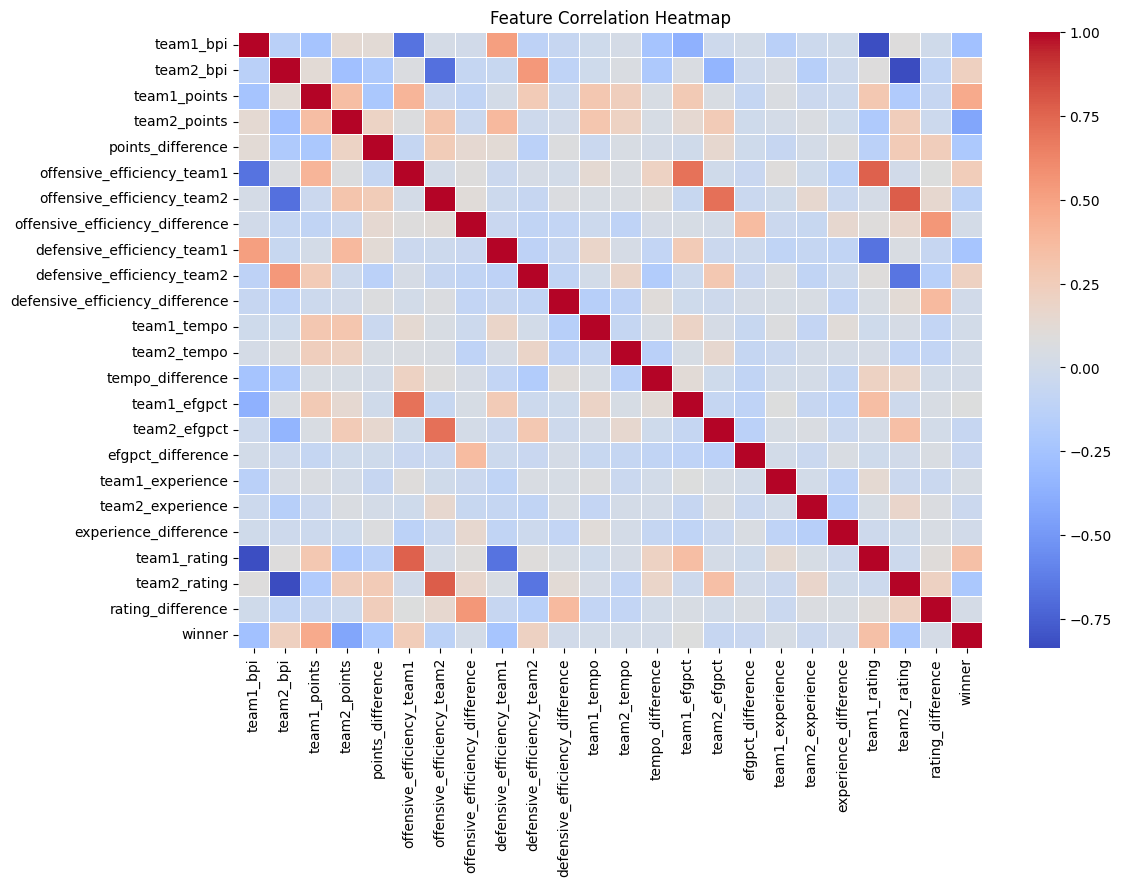

In [ ]:
# Plot a correlation heatmap to visualize the numerical representation of the correlation matrices
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

According to the heatmap, winning is highly correlated with offensive efficiency, points, and ratings, however scoring is negatively impacted by defensive efficiency. Differences in offensive efficiency and rating have the most effects on the winner variable. Team1_rating and team1_bpi are two examples of characteristics that can be unnecessary and could be improved in feature selection.

In [ ]:
# Grouping by winners and computing mean values
mean_comparison = team_matchups.groupby("winner")[numeric_features].mean().T

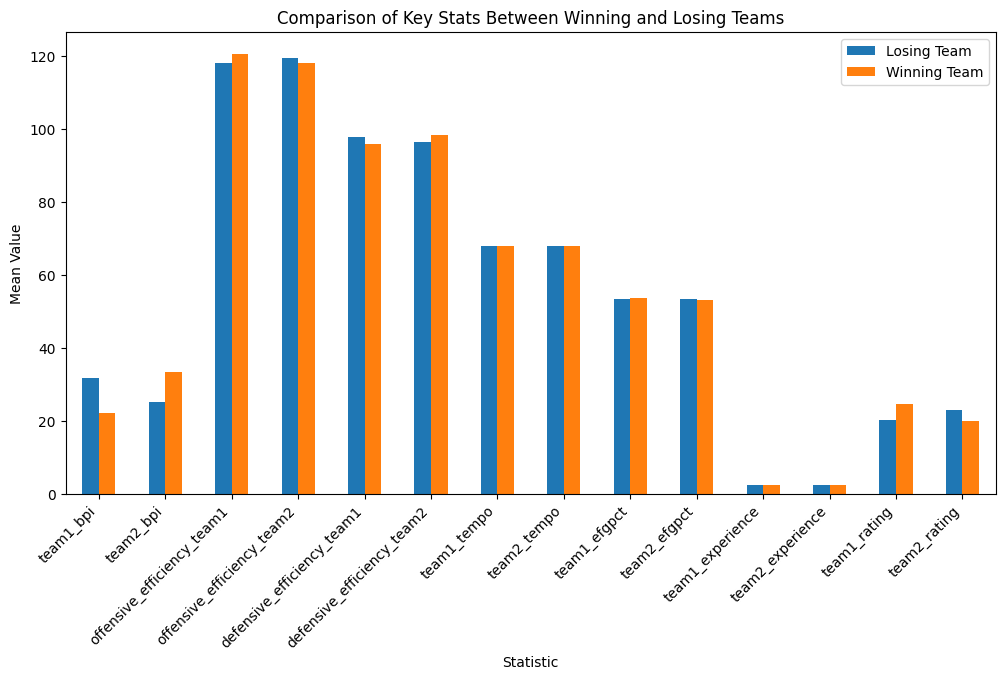

In [ ]:
# Plot mean comparison as a bar chart
mean_comparison.plot(kind="bar", figsize=(12, 6))
plt.title("Comparison of Key Stats Between Winning and Losing Teams")
plt.ylabel("Mean Value")
plt.xlabel("Statistic")
plt.xticks(rotation=45, ha='right')
plt.legend(["Losing Team", "Winning Team"], loc="upper right")
plt.show()

In comparison with losing teams, winning teams typically have greater ratings, offensive efficiency, and BPI.  Both teams have comparable defensive effectiveness and tempo, but victors often have higher shooting percentages and more experience.

In [ ]:
# Define key features to visualize
key_features = [
    "team1_bpi", "offensive_efficiency_team1", "defensive_efficiency_team1",
    "team1_tempo", "team1_efgpct", "team1_experience", "team1_rating"
]

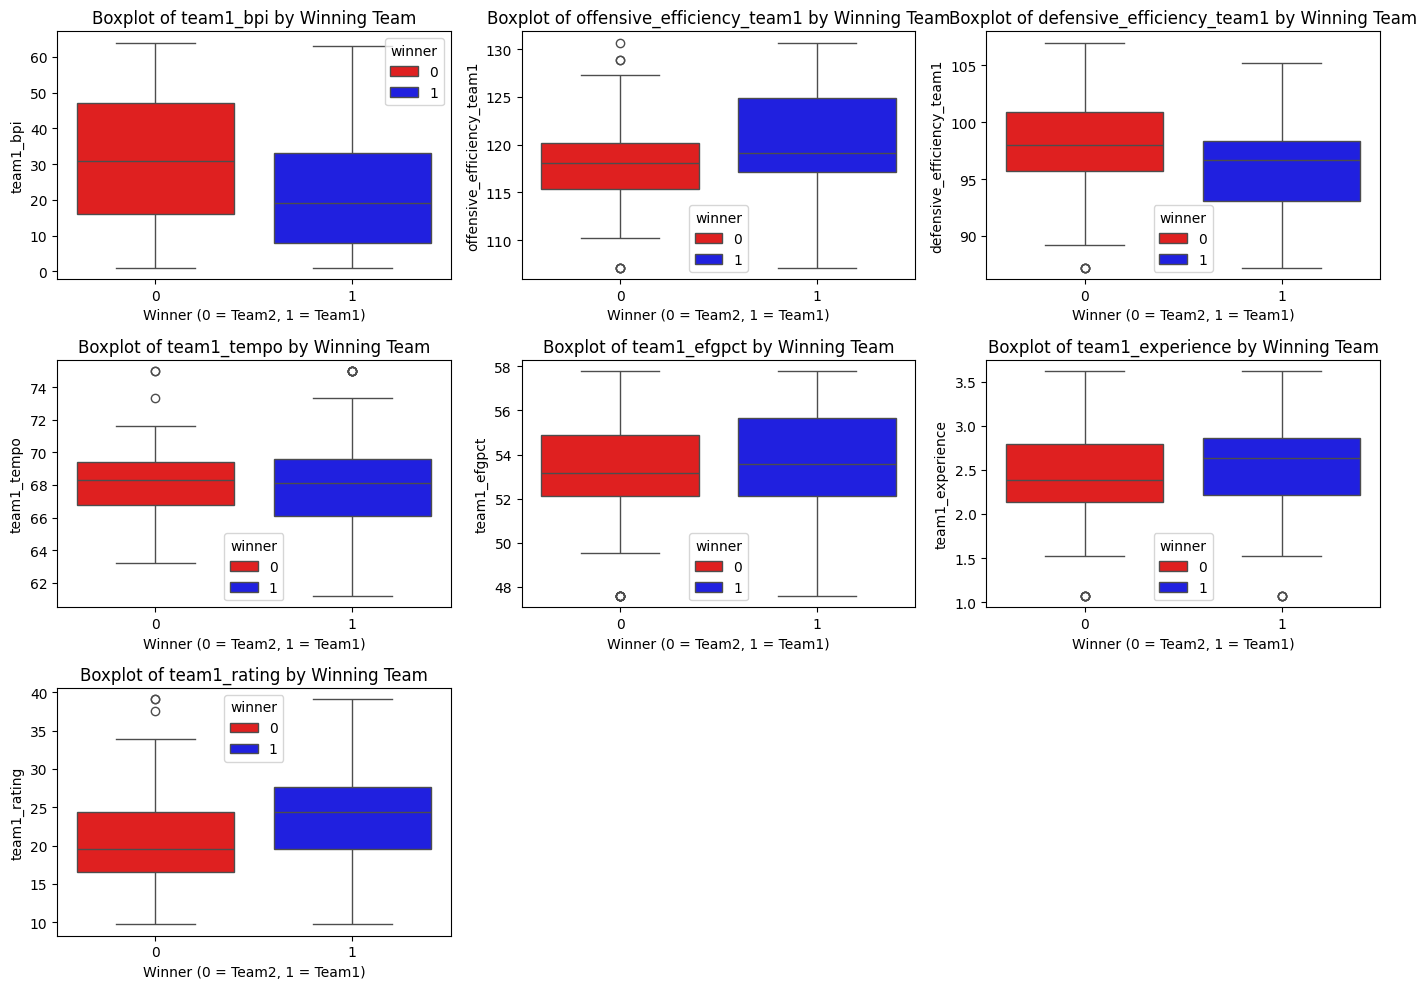

In [ ]:
# Create boxplots for key features grouped by winner
plt.figure(figsize=(14, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=team_matchups["winner"], y=team_matchups[feature], hue=team_matchups["winner"], palette=["red", "blue"])
    plt.title(f"Boxplot of {feature} by Winning Team")
    plt.xlabel("Winner (0 = Team2, 1 = Team1)")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


1. team1_bpi: Winning teams generally have lower BPI values.
2. offensive_efficiency_team1: Winning teams show higher offensive efficiency.
3. defensive_efficiency_team1: Winning teams have better defensive efficiency.
4. team1_tempo: Tempo is similar between winning and losing teams.
5. team1_efgpct: Effective field goal percentage is slightly higher for winners.
6. team1_experience: No major difference in experience between winners and losers.
7. team1_rating: Winning teams tend to have higher ratings.

**Exploratory Data Analysis (EDA) Summary - March Madness ML Predictor**

**1. Data Overview**
- The dataset contains **358 matchups** with **27 columns** capturing team statistics.
- No **missing values** were found in the dataset.

**2. Target Variable Analysis**
- The target variable (`winner`) is slightly imbalanced, with **Team 1 winning fewer matchups than losing**.
- This may suggest that matchups were structured in a way that often favors Team 2.

**3. Feature Distributions**
- **BPI (Basketball Power Index):** Right-skewed, meaning there are more lower-ranked teams.
- **Offensive & Defensive Efficiency:** Normally distributed, suggesting a balance in team strengths.
- **Effective FG% (eFG%):** Most teams have a shooting efficiency between **45%-55%**.
- **Experience & Ratings:** Distributed fairly even, though some teams have significantly more experience.

**4. Correlation Analysis**
- **Stronger Correlations with Winning:**
  - **Offensive & Defensive Efficiency Differences:** Higher efficiency differences increase win probability.
  - **Effective FG% Difference:** Teams with a better shooting percentage tend to win more.
  - **BPI & Rating Differences:** Higher-ranked teams (lower BPI) are more likely to win.

- **Weak or No Correlation:**
  - **Tempo:** The speed of play doesn’t significantly affect winning chances.
  - **Experience:** Having more experienced players doesn’t always translate to more wins.

**5. Winning vs. Losing Teams Analysis**
- **Winning Teams Tend to Have:**
  - **Lower BPI values (stronger ranking).**
  - **Higher offensive efficiency and defensive efficiency.**
  - **Slightly better effective FG% and overall team rating.**

- **No Major Differences in:**
  - **Team Tempo**
  - **Experience Levels**

**6. Boxplot Analysis of Key Features**
- Winning teams have:
  - **Higher offensive efficiency**
  - **Better defensive efficiency**
  - **Higher team rating**
- The variability in **experience and tempo** is similar between winners and losers, reinforcing that they are **not strong predictors**.

---

> **Final Thoughts:**  
> Our findings suggest that offensive efficiency, defensive efficiency, and shooting percentage are the most important factors in predicting wins. We have uses these insights to guide our model design.


### Missing Values

In [ ]:
team_matchups.isna().sum()

,0
team1,0
team1_bpi,0
team2,0
team2_bpi,0
team1_points,0
team2_points,0
points_difference,0
offensive_efficiency_team1,0
offensive_efficiency_team2,0
offensive_efficiency_difference,0


In [ ]:
team_matchups.dtypes

,0
team1,object
team1_bpi,int64
team2,object
team2_bpi,int64
team1_points,int64
team2_points,int64
points_difference,int64
offensive_efficiency_team1,float64
offensive_efficiency_team2,float64
offensive_efficiency_difference,float64


In [ ]:
team_matchups = team_matchups.drop(['team1', 'team2'], axis=1)

In [ ]:
team_matchups.head()

,team1_bpi,team2_bpi,team1_points,team2_points,points_difference,offensive_efficiency_team1,offensive_efficiency_team2,offensive_efficiency_difference,defensive_efficiency_team1,defensive_efficiency_team2,...,team1_efgpct,team2_efgpct,efgpct_difference,team1_experience,team2_experience,experience_difference,team1_rating,team2_rating,rating_difference,winner
0,21,9,63,101,38,121.1,125.2,4.1,100.8,97.9,...,52.05,56.41,4.36,2.72,2.97,0.12,20.3,27.3,7.0,0
1,35,34,80,72,8,118.1,116.7,1.4,98.6,100.7,...,53.70,52.90,0.81,2.16,2.85,1.46,19.5,16.0,3.5,1
2,27,11,89,92,3,119.2,115.4,3.8,102.0,92.2,...,54.26,53.14,1.12,2.24,3.62,0.01,17.2,23.2,6.0,0
3,49,26,72,64,8,113.7,116.5,2.8,96.6,95.0,...,51.25,52.94,1.69,2.45,2.23,0.19,17.1,21.5,4.4,1
4,3,2,74,69,5,130.7,124.9,5.8,93.1,89.5,...,56.05,53.21,2.84,2.79,2.63,1.25,37.6,35.4,2.2,1


## Machine Learning
---

### Splitting the dataset

In [ ]:
target = team_matchups['winner']
features = team_matchups.drop(['winner'], axis=1)

In [ ]:
print(features.shape)
print(target.shape)

(357, 23)
(357,)


In [ ]:
#splitting dataset into training, validation and test sets
features_train, features_rem, target_train, target_rem = train_test_split(features, target, test_size= 0.4, random_state=7)
features_valid, features_test, target_valid, target_test = train_test_split(features_rem, target_rem, test_size=0.5, random_state=7)

In [ ]:
print(features_train.shape)
print(target_train.shape)

(214, 23)
(214,)


In [ ]:
print(features_valid.shape)
print(target_valid.shape)

(71, 23)
(71,)


In [ ]:
print(features_test.shape)
print(target_test.shape)

(72, 23)
(72,)


### CatBoostClassifier Model

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],  # More iterations for boosting
    'depth': [3, 6, 10]  # Controls tree depth
}

# Initialize CatBoostClassifier
model = CatBoostClassifier(random_state=7, verbose=0, loss_function="Logloss")  # Silent training

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='accuracy', verbose=2)

# Fit model
grid_search.fit(features_train, target_train)

# Get best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on validation set
predictions_team_valid = best_model.predict(features_valid)

# Calculate accuracy on validation set
accuracy_team1_valid = accuracy_score(target_valid, predictions_team_valid)

print("Validation Accuracy:", accuracy_team1_valid)
print("Best Parameters:", best_params)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] END .......depth=3, learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END .......depth=3, learning_rate=0.01, n_estimators=50; total time=   0.3s
[CV] END .......depth=3, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END .......depth=3, learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=100; total time=   0.3s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=100; total time=   0.2s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=100; total time=   0.3s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=100; total time=   0.3s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=200; total time=   0.5s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=200; total time=   0.7s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=200; total time=   0.7s
[CV] END ......depth=3, learning_rate=0.01, n_e

In [ ]:
# Predict on the test set
predictions_team_test = best_model.predict(features_test)

# Evaluate on the test set
accuracy_team_test = accuracy_score(target_test, predictions_team_test)

print("Test Set Accuracy:", accuracy_team_test)

Test Set Accuracy: 0.9861111111111112


### Sanity Check

<Axes: xlabel='winner'>

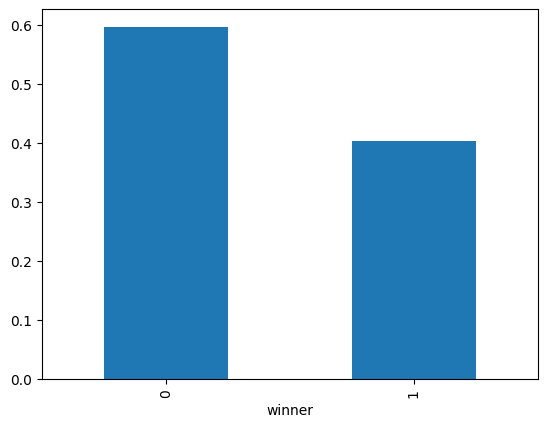

In [ ]:
target_team_counts = team_matchups['winner'].value_counts(normalize=True)
target_team_counts.plot(kind='bar')

### Upsampling the dataset

In [ ]:
train = pd.concat([features_train, target_train], axis=1)

In [ ]:
train.head()

,team1_bpi,team2_bpi,team1_points,team2_points,points_difference,offensive_efficiency_team1,offensive_efficiency_team2,offensive_efficiency_difference,defensive_efficiency_team1,defensive_efficiency_team2,...,team1_efgpct,team2_efgpct,efgpct_difference,team1_experience,team2_experience,experience_difference,team1_rating,team2_rating,rating_difference,winner
246,22,53,74,80,6,121.9,113.2,8.7,97.7,97.6,...,52.13,51.57,0.56,1.07,2.79,1.71,24.2,15.6,8.6,0
345,20,17,75,89,14,122.4,113.9,8.5,104.1,89.2,...,55.74,49.54,6.20,1.75,2.36,0.60,18.3,24.7,6.4,0
69,23,8,72,67,5,115.9,124.3,8.4,93.0,96.7,...,47.60,55.64,8.04,2.97,2.67,0.29,22.9,27.6,4.7,1
36,25,23,73,77,4,116.1,115.9,0.2,98.0,93.0,...,55.36,47.60,7.76,2.65,2.97,0.41,18.1,22.9,4.8,0
40,24,31,85,96,11,123.5,118.1,5.4,101.2,96.0,...,57.79,51.85,5.95,1.92,3.46,0.39,22.3,22.1,0.2,0


winner
0    0.579439
1    0.420561
Name: proportion, dtype: float64
winner
0    124
1     90
Name: count, dtype: int64


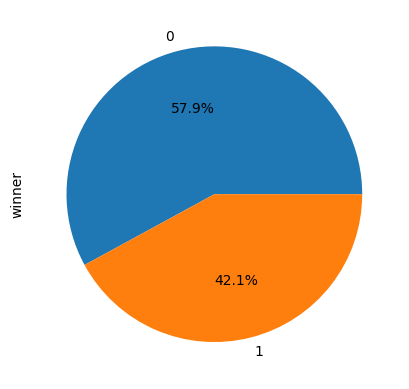

In [ ]:
# numerical/visual representation of composition of the class proportions before upsampling
train.groupby('winner').size().plot(kind='pie', y='winner', label='winner', autopct='%1.1f%%')
print(train['winner'].value_counts(normalize = True)) # Check the target distribution
print(train['winner'].value_counts())

In [ ]:
# upsampling used to address class imbalance
majority = train[train['winner'] == 0]
minority = train[train['winner'] == 1 ]

minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=7)

train_us =pd.concat([majority, minority_upsampled])

winner
0    0.5
1    0.5
Name: proportion, dtype: float64
winner
0    124
1    124
Name: count, dtype: int64


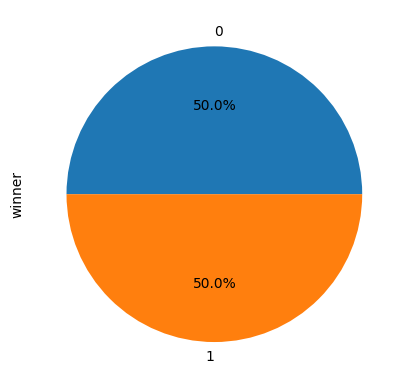

In [ ]:
# numerical/visual representation of composition of the class proportions after upsampling
train_us.groupby('winner').size().plot(kind='pie', y='winner', label='winner', autopct='%1.1f%%')
print(train_us['winner'].value_counts(normalize = True)) # Check the target distribution
print(train_us['winner'].value_counts())

## Data Inspection of Upsampled DDataset

In [ ]:
train_us.head()

,team1_bpi,team2_bpi,team1_points,team2_points,points_difference,offensive_efficiency_team1,offensive_efficiency_team2,offensive_efficiency_difference,defensive_efficiency_team1,defensive_efficiency_team2,...,team1_efgpct,team2_efgpct,efgpct_difference,team1_experience,team2_experience,experience_difference,team1_rating,team2_rating,rating_difference,winner
246,22,53,74,80,6,121.9,113.2,8.7,97.7,97.6,...,52.13,51.57,0.56,1.07,2.79,1.71,24.2,15.6,8.6,0
345,20,17,75,89,14,122.4,113.9,8.5,104.1,89.2,...,55.74,49.54,6.20,1.75,2.36,0.60,18.3,24.7,6.4,0
36,25,23,73,77,4,116.1,115.9,0.2,98.0,93.0,...,55.36,47.60,7.76,2.65,2.97,0.41,18.1,22.9,4.8,0
40,24,31,85,96,11,123.5,118.1,5.4,101.2,96.0,...,57.79,51.85,5.95,1.92,3.46,0.39,22.3,22.1,0.2,0
265,50,3,70,89,19,118.4,130.7,12.3,101.8,93.1,...,54.78,56.05,1.27,2.31,2.79,0.48,16.6,37.6,21.0,0


In [ ]:
#output of dataset column names, data types & presence of any null values
train_us.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 246 to 203
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   team1_bpi                        248 non-null    int64  
 1   team2_bpi                        248 non-null    int64  
 2   team1_points                     248 non-null    int64  
 3   team2_points                     248 non-null    int64  
 4   points_difference                248 non-null    int64  
 5   offensive_efficiency_team1       248 non-null    float64
 6   offensive_efficiency_team2       248 non-null    float64
 7   offensive_efficiency_difference  248 non-null    float64
 8   defensive_efficiency_team1       248 non-null    float64
 9   defensive_efficiency_team2       248 non-null    float64
 10  defensive_efficiency_difference  248 non-null    float64
 11  team1_tempo                      248 non-null    float64
 12  team2_tempo              

### Splitting the Upsampled Dataset

In [ ]:
target_train_us = train_us['winner']
features_train_us = train_us.drop(['winner'], axis=1)

In [ ]:
print(features_train_us.shape)
print(target_train_us.shape)

(248, 23)
(248,)


### Models using Upsampled Dataset

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],  # More iterations for boosting
    'depth': [3, 6, 10]  # Controls tree depth
}

# Initialize CatBoostClassifier
model = CatBoostClassifier(random_state=7, verbose=0, loss_function="Logloss")  # Silent training

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='accuracy', verbose=2)

# Fit the model
grid_search.fit(features_train_us, target_train_us)

# Get best model and parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on validation set
predictions_team_1_valid = best_model.predict(features_valid)
accuracy_team_1_valid = accuracy_score(target_valid, predictions_team_1_valid)

print("Validation Accuracy:", accuracy_team_1_valid)
print("\nBest Parameters:", best_params)


Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] END .......depth=3, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END .......depth=3, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END .......depth=3, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END .......depth=3, learning_rate=0.01, n_estimators=50; total time=   0.1s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=100; total time=   0.1s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=100; total time=   0.1s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=100; total time=   0.1s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=100; total time=   0.1s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=200; total time=   0.2s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=200; total time=   0.2s
[CV] END ......depth=3, learning_rate=0.01, n_estimators=200; total time=   0.2s
[CV] END ......depth=3, learning_rate=0.01, n_e

In [ ]:
# Predict on the test set
predictions_team_1_test = best_model.predict(features_test)
accuracy_team_1_test = accuracy_score(target_test, predictions_team_1_test)

print("Test Set Accuracy:", accuracy_team_1_test)

Test Set Accuracy: 0.9722222222222222


## Model Analysis

After running the Catboost model, it appears the valid accuracy (0.89) and test accuracy (0.97) after balancing the classes are both lower than the validation accuracy (0.92) & test accuracy (0.99) before upsampling.

For the model training before and after upsampling, the accuracy of the validation set to the test set increases. This indicates that overfitting or underfitting isnt' an issue.

## Conclusion

1. This project aimed to predict NCAA Tournament winners using statistics of matchups between November 2024 to February 2025.

2. The Exploratory Data Analysis (EDA) revealed that offensive efficiency, rating differences, and BPI were key indicators of success.

3. Defensive efficiency had a less important relationship with winning.

4. While tempo and experience are the same for winners and losers, winning teams typically have greater BPIs, offensive efficiency, and ratings.

5. Feature correlation analysis helped in optimizing the dataset by identifying weaker attributes.

6. The model first obtained a test accuracy of 0.99 and a validation accuracy of 0.92 using CatBoost.  The validation accuracy decreased to 0.89 and the test accuracy to 0.97 after upsampling to balance classes, indicating that the change added a little amount of uncertainty without significantly improving generalization.

7. To fix the dataset's class imbalance, we upsampled.  The model may have favored the majority class (losing teams) because there were initially more losing games than winning games.

8. The model performed strongly in predicting match outcomes, demonstrating that Catboost model can effectively analyze team matchups.

9. The model's performance stayed continuously high after upsampling, despite minor decreases in validation and test accuracy, indicating that it was resilient to changes in class balancing.

